In [212]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from pathlib import Path
import os
import shutil
import sys
import PIL 
from scipy import stats
sys.path.append('/workspace/detect-me/product_classifier/scripts')
from utils.data_loader import load_data_flow_from_dataframe

In [213]:
import tensorflow as tf

# DATA GENerator 

In [255]:
def return_dataframe(dirr, subset : str):
    list_images = list(Path(dirr).rglob('*.jpg'))
    df = pd.DataFrame( {'filepath' : list_images,
                        'partial_filepath' : [pathlib.Path(str(x).split('/data/')[1]) for x in list_images]})
    
    df_parts = pd.DataFrame(
        df.partial_filepath.apply(lambda x : x.parts).to_list())
    
    df = pd.concat([df, df_parts],axis=1)

    df = df.rename({0:'seccat', 
                    1 :'subset',
                    2:'vms',
                    3:'filename'},
                   axis=1)

    df = df[df['subset'] == subset]
    df = df[~df.filepath.astype(str).str.contains('ipynb_checkpoints')]
    
    
    # remove over sample data from training 
    if subset == 'train-val':
        df = df.reset_index(drop=True)
        df = df.reset_index()

        counts = df.groupby('seccat').count()['filepath']

        oversample_data = counts[(np.abs(stats.zscore(counts)) > 3)]
        print('oversample_data',oversample_data.index.values)

        oversample_data_df = df[df.seccat.isin(oversample_data.index)]

        counts_oversample_data =  oversample_data_df.groupby(['seccat', 'vms']).count()['filepath']

        counts_oversample_data_ix = counts_oversample_data[np.abs(stats.zscore(counts_oversample_data)) > 2]

        D = df[df.vms.isin(counts_oversample_data_ix.reset_index()['vms'])]

        include = D.groupby('vms')['index'].sample(int(counts_oversample_data.mean()))
        exclude = D[~D.index.isin(include.index)]
        print('!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(f'excluding {exclude.shape} from trainig')
        print('!!!!!!!!!!!!!!!!!!!!!!!!!')
        df = df.assign(exclude_flag = np.where(df.index.isin(exclude.index), True, False))
        df = df[df.exclude_flag==False]
    

    if df.empty:
        raise Exception(
            '''NO NO returned dataframe is empty,
            maybe folder struct is not right.
            \nData/ Second category / vms ''')
    
    df_selected = df[['filepath','seccat']]

    df_selected = df_selected.assign(seccat = np.where(df_selected.seccat == 'milk', 'shyr', df_selected.seccat))
    df_selected = df_selected.assign(seccat = np.where(df_selected.seccat == 'yogurt', 'mast', df_selected.seccat))

    df_selected.columns = ['filename', 'class']

    df_selected = df_selected.astype({'filename' :str})

    return df_selected

In [256]:
df = return_dataframe(data_dir, 'test')

In [258]:
df['class'].value_counts()

shyr                                         737
tn_mahy                                      254
abmyvh                                       230
shstshvy_lbas                                229
chay_v_dmnvsh                                137
lvazm_ykbarmthrf                             127
bhdasht_kvdk                                 116
mrba                                         103
ghzay_nymh_amadh                              99
ghhvh_v_hat_chaklt                            97
nvshabh                                       97
knsrv_v_kmpvt                                 87
maealshaayr                                   84
shklat_thbhanh                                76
dstmal_tvalt                                  69
kshk                                          55
rb                                            50
pak_knndh_v_zdaafvny_knndh_srvys_bhdashty     47
chyps                                         41
nvshydny_anrzhy_za                            38
brnj                

In [216]:
cat ='by_category'
data_dir = f'/workspace/detect-me/product_classifier/data/'

data_flow_df = \
load_data_flow_from_dataframe(
    data_dir ,
    (224,224),
    1,
)
print('\n'.join(data_flow_df.keys()))

____________________
110
                                               filename class
1113  /workspace/detect-me/product_classifier/data/m...  shyr
1114  /workspace/detect-me/product_classifier/data/m...  shyr
1115  /workspace/detect-me/product_classifier/data/m...  shyr
1116  /workspace/detect-me/product_classifier/data/m...  shyr
1117  /workspace/detect-me/product_classifier/data/m...  shyr
110
____________________
59
len classes_set 110
Found 88296 validated image filenames belonging to 110 classes.
Found 22123 validated image filenames belonging to 110 classes.
Found 3360 validated image filenames belonging to 110 classes.
train
validation
test
num_classes
class_indices
samples


In [10]:
# data_flow['train'].total_batches_seen
# data_flow['train'].target_size

In [11]:
# val_percent = 0.8
# train_validation_df = return_dataframes(train_val_dir, sold_DR)  
# train_df = train_validation_df.groupby('class', group_keys=False).\
#                                     apply(lambda x: x.sample(max(int(val_percent*len(x)), 1)))
# validation_df = train_validation_df[~train_validation_df.filename.isin(train_df.filename)]  
# test_df = return_dataframes(test_dir, sold)

# FLOW

In [218]:
FLOW = data_flow_df

***

(110, 2)


<AxesSubplot:>

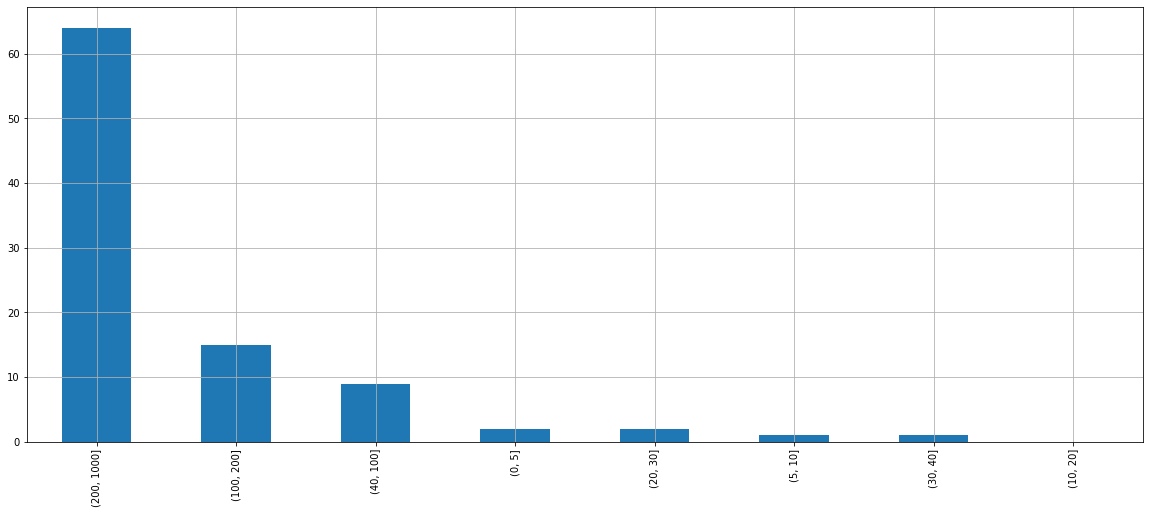

In [219]:
counts = np.unique(FLOW['train'].classes, return_counts=True)
df = pd.DataFrame({'labels':counts[0], 'counts':counts[1]}).set_index('labels')
df = df.assign(cuts = pd.cut(df['counts'], bins=[0,5,10,20,30,40,100,200,1000]))
print(df.shape)
df['cuts'].value_counts().plot(kind='bar', figsize=(20,8), grid=True)

(110, 2)


<AxesSubplot:>

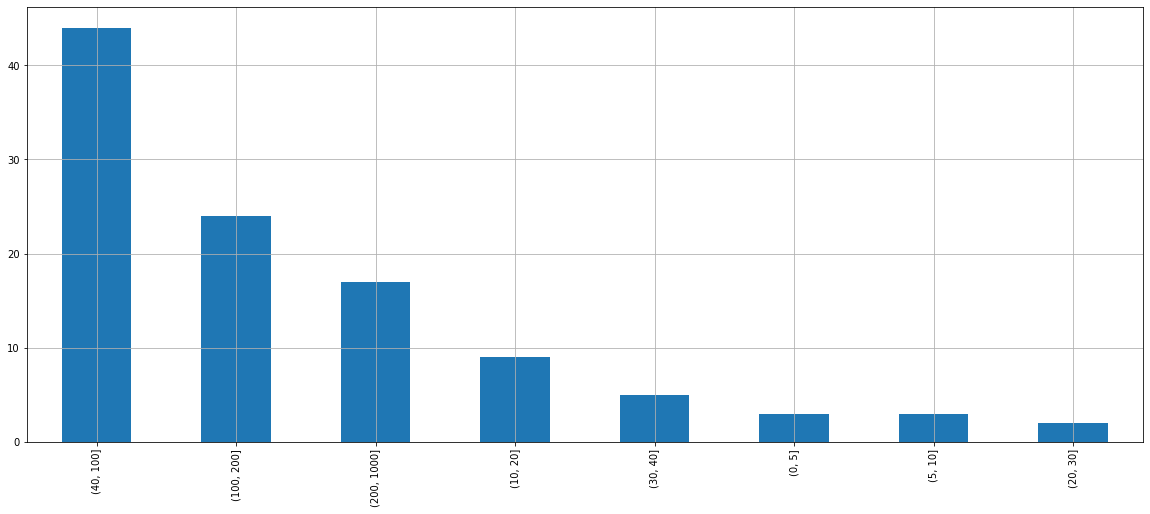

In [220]:
counts = np.unique(FLOW['validation'].classes,
                   return_counts=True)
df = pd.DataFrame({'labels':counts[0],
                   'counts':counts[1]}).set_index('labels')
df = df.assign(cuts = pd.cut(df['counts'],
                             bins=[0,5,10,20,30,40,100,200,1000]))
print(df.shape)
df['cuts'].value_counts().plot(kind='bar',
                               figsize=(20,8),
                               grid=True)

## TRAIN VALIDATION

/workspace/keras-retinanet/keras-retina-venv/lib/python3.8/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


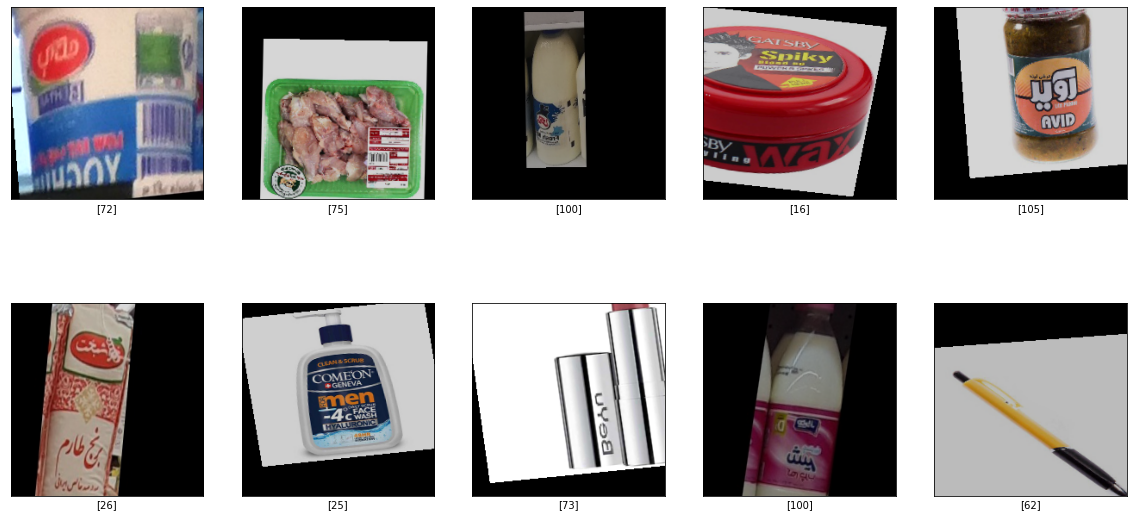

In [221]:
def plot_from_flow(flow , howmany, ncols):
    rows = math.ceil(howmany/ncols)
    plt.figure(figsize=(20,rows*5))
    for i in range(howmany):
        plt.subplot(rows,ncols,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image , label = flow.__next__()
        image = image.astype(np.uint8)
        plt.imshow(image[0,...],
    #                cmap=plt.cm.binary
                  )
        plt.xlabel(np.argmax(label, axis=1))
    plt.show()
plot_from_flow(data_flow_df['train'], 10, 5)

## test

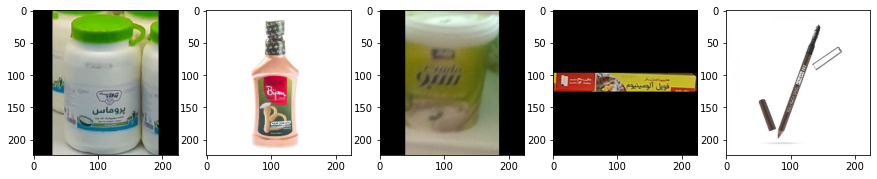

In [231]:
dog_generator = data_flow_df['validation']
dog = [next(dog_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(15, 6))
l = [ax[i].imshow((dog[i][0][0]).astype(np.uint)) for i in range(0,5)]

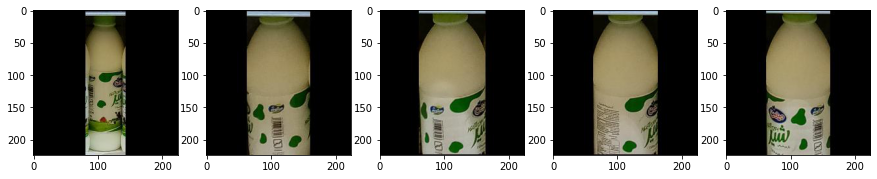

In [254]:
dog_generator = data_flow_df['test']
dog = [next(dog_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(15, 6))
l = [ax[i].imshow((dog[i][0][0]).astype(np.uint)) for i in range(0,5)]

# CHECK TEST TRAIN 

In [223]:
datafolder = pathlib.Path(f'/workspace/detect-me/product_classifier/data/{cat}')
train_folder = datafolder /'train-val'
test_folder = datafolder /'test'

In [229]:
def take_images_by_vms(vms, folder, howmany=None, sort=False):
    vms_folder=list(pathlib.Path(folder).rglob(vms))[0]
#     print(vms_folder)
    list_images = sorted(list(pathlib.Path(vms_folder).rglob('*.jpg')), reverse=False)
    print('len list_images')
    print(len(list_images))
#     print(list_images[0])
#     images_p = np.random.choice(list_images, number)
    images = [(np.array(PIL.Image.open(image)),image) for image in list_images]
    
    if howmany:
        return images[:howmany]  
    return images              

In [230]:
def plott(vms, folder,howmany=None):
    
    images = take_images_by_vms(vms, folder, howmany=howmany)
    print(vms)
    cols = 5
    rows = len(images)//cols +1

    fig, axes = plt.subplots(ncols=cols,
                nrows=rows,
    #              sharex=True,
    #              sharey=True,
                 squeeze=True,
                 figsize=(20,rows*4))
    fig.subplots_adjust(left=0,
                        right=1,
                        bottom=0,
                        top=1)
    images_path = []
    for ax,(image,path) in zip(axes.flatten(),
                               images):
        images_path.append(path)
        t = pathlib.Path(path).name
        t = t[:15]
#         try:
#             t1 = float(t.split('-')[0])
#             t2 = t.split('-')[1]
#         except:
#             t1 = t
#             t2=''
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(t)
#         ax.set_title(f'{t1:.3}\n{t2}')
        ax.axis('tight')
    plt.tight_layout()
    plt.show()
    return images_path

## list VMS

In [21]:
# class_indices = FLOW['train'].class_indices
# list_vms = list(class_indices)

# # for vms in list_vms[:10]:
# #     plott(vms,train_folder)

# label_map_df = pd.DataFrame(FLOW['train'].class_indices.items(), columns = ['vms', 'code'])

# xtrain,xtrain_count= np.unique(FLOW['train'].classes, return_counts=True)
# train_count = pd.DataFrame({'lables' : xtrain,
#                           'counts' : xtrain_count}
#                         )
# c = label_map_df.set_index('code').\
#         join(train_count.set_index('lables'))

# less_than_five_in_training = c[c['counts'] <= 5]

# less_than_five_in_training.shape

# RIDI 

In [23]:
# done = []
# done.append(vms)
# pd.Series(done).to_csv('done_checking.csv')

# print(len(done))

# print(done[-5:])
# i=0
# # i +=1

# vms=need_to_corect[i]
# vms

In [ ]:
# add_images = []
# remove_images = []
# correct = []

# class_indices = FLOW['train'].class_indices
# list_vms = list(class_indices)

# g = (x for x in list_vms)

In [31]:
# vms = next(g)
# vms

'106667'

In [30]:
# correct.append(vms)
# remove_images.append(vms)
# add_images.append(vms)

# PRED FOLDER

In [226]:
folder_preds = '/workspace/keras-retinanet/images_from_store/temp/vms_preds/'

In [227]:
# images_path = plott(vms,folder_preds, howmany=30)

# TRAIN

In [228]:
train_val_dir

'/workspace/detect-me/product_classifier/data/by_category/train-val'

In [27]:
csv_codes = pd.read_csv('/workspace/detect-me/product_classifier/data/by_category/secCat_codes.csv')

In [34]:
(set(csv_codes['SecCat'].str.strip()) - set(csv_codes['SecCat']) | 
set(csv_codes['SecCat']) - set(csv_codes['SecCat'].str.strip()))

set()

In [44]:
dict_codes = csv_codes[['SecCat', 'SecCat_codes']].set_index('SecCat_codes').to_dict()['SecCat']

In [46]:
dict_codes[43]

'دوغ'

len list_images
47
46


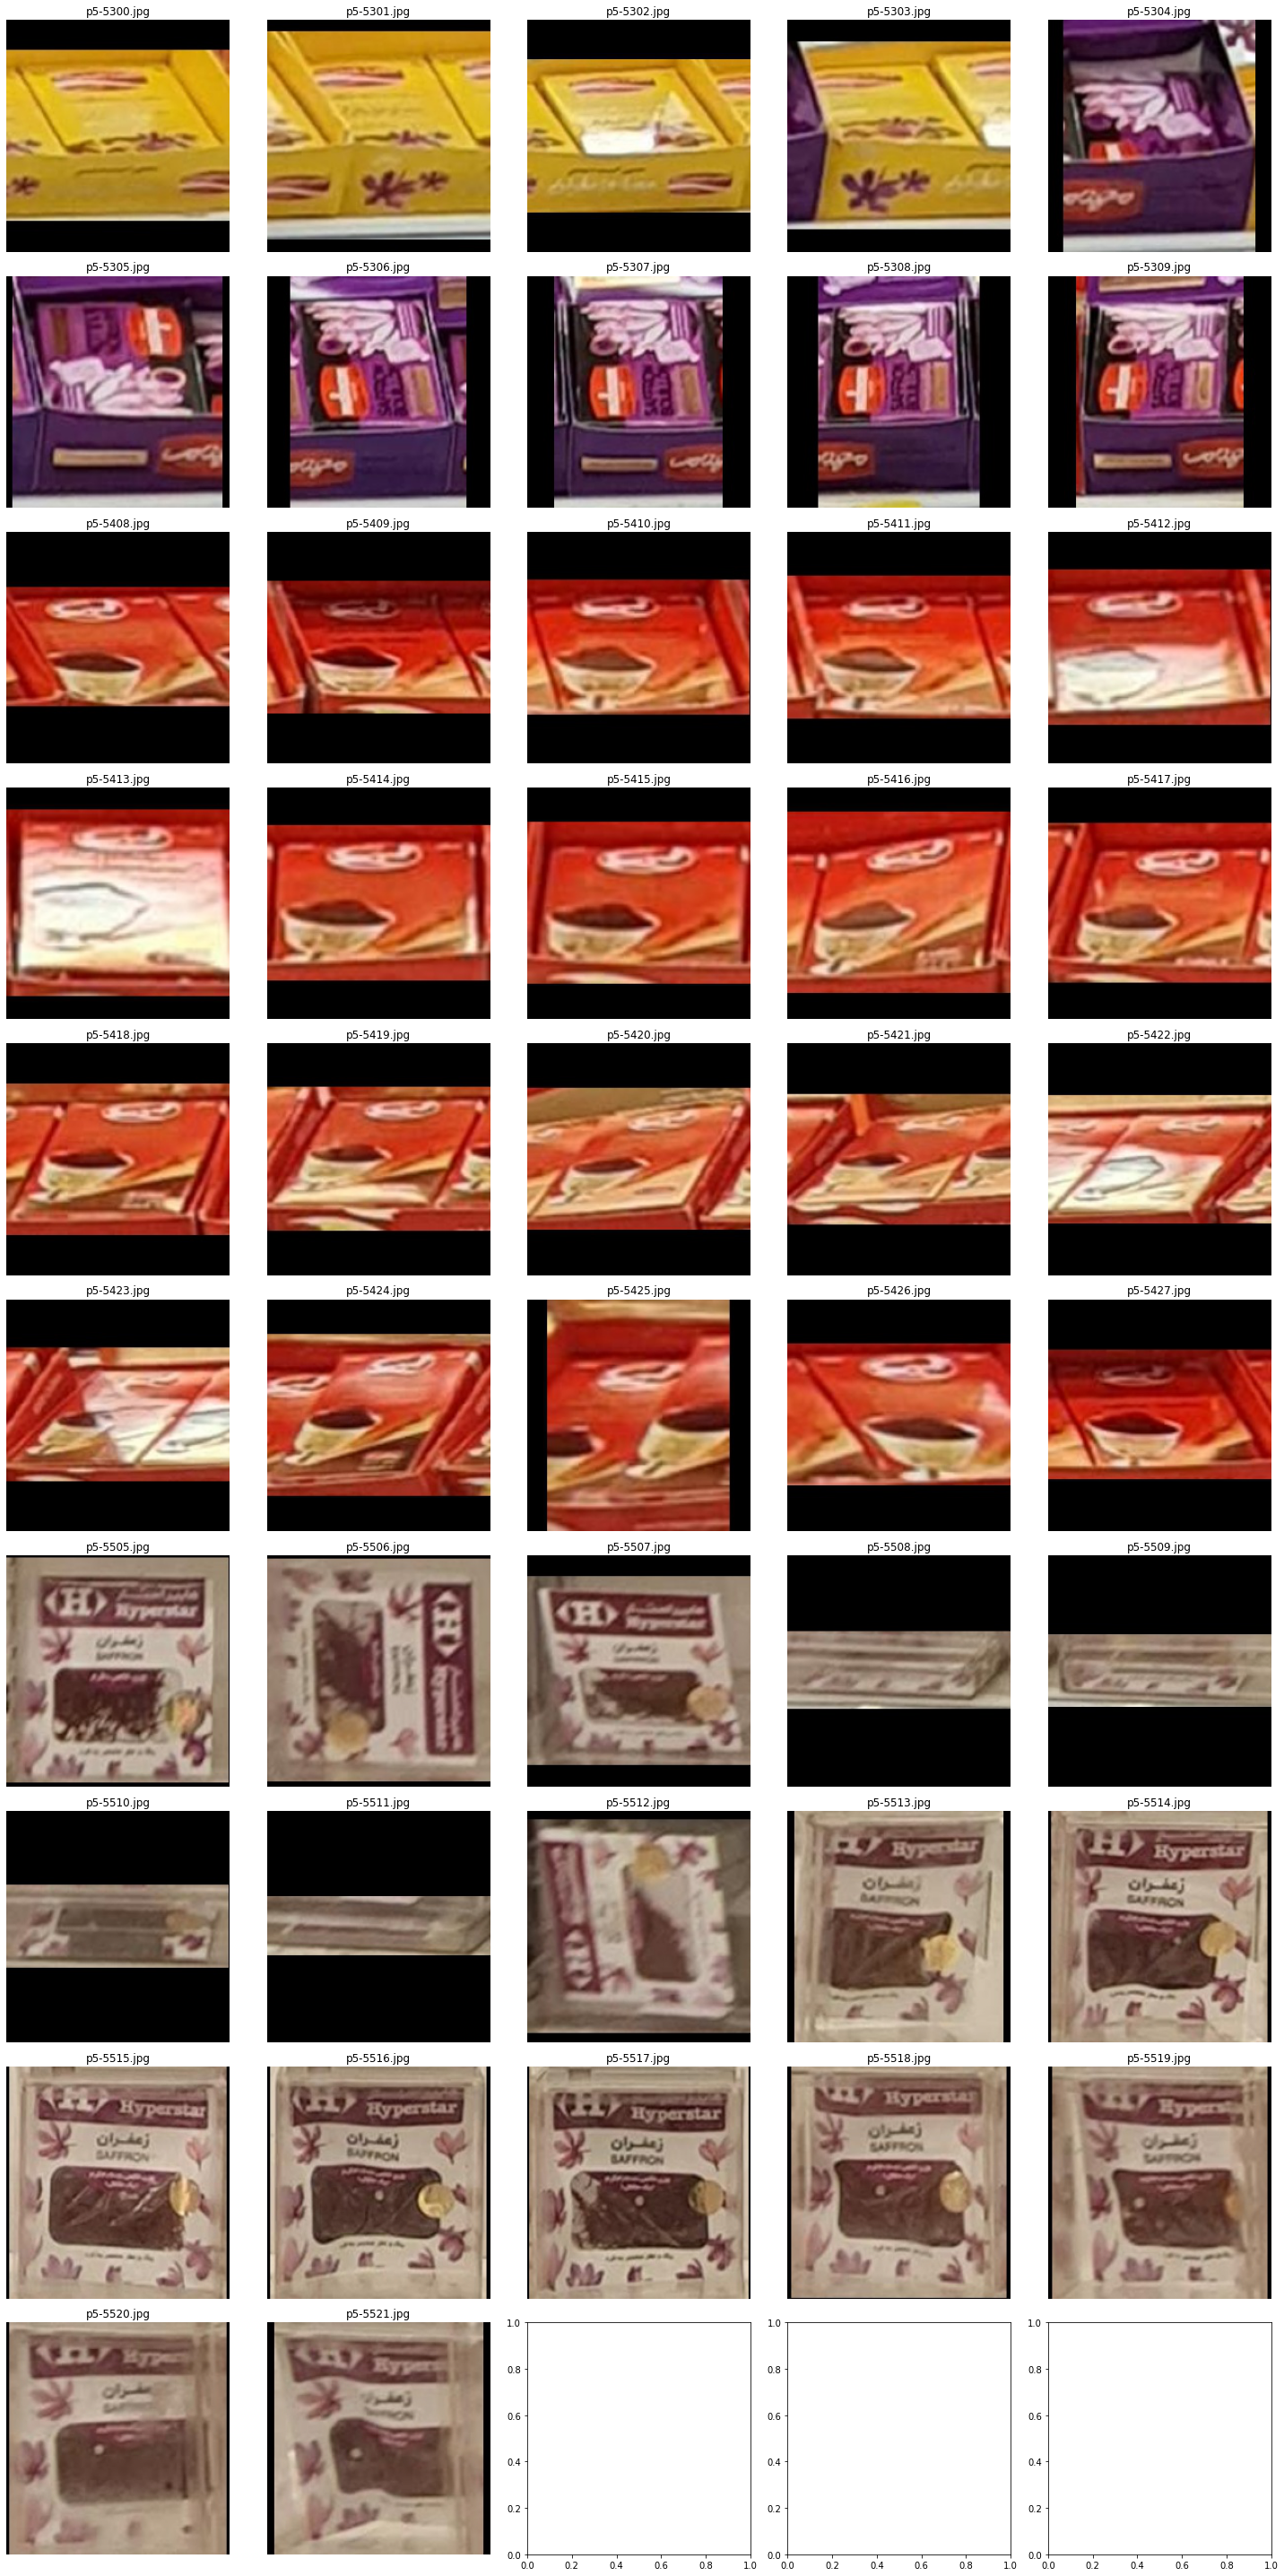

In [51]:
images_path = plott('46',data_dir, howmany=50)

# TEST 

len list_images
3
106667


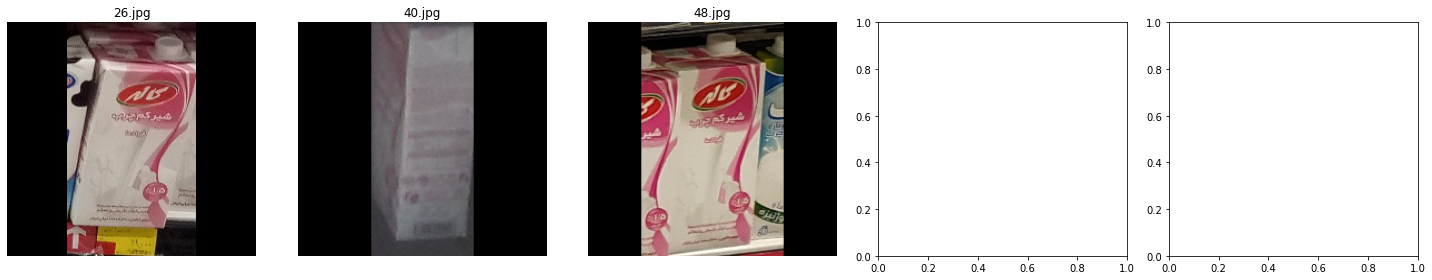

[PosixPath('/workspace/detect-me/product_classifier/data/milk/test/106667/26.jpg'),
 PosixPath('/workspace/detect-me/product_classifier/data/milk/test/106667/40.jpg'),
 PosixPath('/workspace/detect-me/product_classifier/data/milk/test/106667/48.jpg')]

In [33]:
plott(vms,test_folder)

In [73]:
# !find /workspace/detect-me/product_classifier/data/milk/train-val/$vms/ -name '9.jpg' -delete

In [109]:
# !find /workspace/detect-me/product_classifier/data/milk/test/$vms/ -name '8.jpg' -delete

In [110]:
len(list((test_folder / vms).rglob('*')))

0

In [111]:
list_images_moveto_test = ['p4-307']

In [112]:
def make_sth_random():
    s = np.random.choice(list('abcdefghijklmnopqrstuvwxyz'),4)
    s = ''.join(s)
    n = np.random.randint(low=0, high=1000)
    m = np.random.randint(low=0, high=1000)
    return f'{s}{m}{n}' 

In [113]:
for image_number in list_images_moveto_test:
    pathimage_to_move = [p for p in images_path if p.name==f'{image_number}.jpg'][0]
    vms_folder =  pathimage_to_move.parents[0].name
    name_file = pathimage_to_move.name
    
    if not (test_folder / vms_folder).exists():
        print('creating folder')
        os.makedirs(test_folder / vms_folder)
        
    dest_path = test_folder / vms_folder / name_file
    if dest_path.exists():
        new_name = make_sth_random()
        print(f'exists -> new name {new_name}')
        dest_path = test_folder / vms_folder /new_name
    shutil.move(str(pathimage_to_move) , str(dest_path))
    print(f'move ::{str(pathimage_to_move)} to\n  {str(dest_path)}')

creating folder
move ::/workspace/detect-me/product_classifier/data/milk/train-val/326491/p4-307.jpg to
  /workspace/detect-me/product_classifier/data/milk/test/326491/p4-307.jpg


In [ ]:
# def move_from_folder_to_folder(list_names, source='train-val'):
#     for file in list_names:
        
    
    

In [33]:
vmS = list(set(FLOW['train'].class_indices))

In [34]:
len(vmS)

337

In [35]:
ALL_PRODUCTS = pd.read_excel('/workspace/detect-me/all_products.xlsx', index_col=0, engine='openpyxl')
ALL_PRODUCTS = ALL_PRODUCTS.set_index('vms_food_id')

In [36]:
ALL_PRODUCTS.shape

(99650, 8)

In [37]:
set([int(x) for x in vmS]) - set(ALL_PRODUCTS.index)

{9999999, 20028187}

In [38]:
c = c.astype({'vms' : int})

In [42]:
ALL_PRODUCTS_milk = ALL_PRODUCTS.join(c.set_index('vms'), how='right')

In [43]:
ALL_PRODUCTS_milk = ALL_PRODUCTS_milk.sort_values(by=['brand_title_fa','counts' ])

In [44]:
vmS = ALL_PRODUCTS_milk.index

In [45]:
vmS = vmS.astype(str)

In [47]:
V1 = vmS[:100]
V2 = vmS[100:200]
V3 = vmS[200:]

In [49]:
V=V1

In [50]:
from PIL import Image

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True, figsize=(20, len(V)//5 * 2))

subfigs = fig.subfigures(len(V)//6+1, 6)

for outerind, (subfig, vms) in enumerate(zip(subfigs.flat, V)):
    
    axs = subfig.subplots(1, 2, sharex=True, sharey=True,)
    
    subfig.suptitle(f'vms :: {vms}', fontsize='x-large')
    images = take_images_by_vms(vms,train_folder,2)
    images_arr = [x[0] for x in images]
    
    [ax.axis('off') for ax in axs.flat]
    for innerind, (ax,img) in enumerate(zip(axs.flat, images_arr)):
        ax.set_title(f'vms={vms}, {innerind}', fontsize='small')
        ax.imshow(img)
#         ax.set_xticks([])
#         ax.set_yticks([])
        ax.axis('off')
        ax.axis('tight')
# plt.axis('off')   
plt.savefig('all2.png')
Image.open('all2.png').convert('RGB').save('train-val-images-part1.jpg','JPEG')
# plt.show()
# plt.savefig('all.jpg')

In [52]:
V=V2

In [ ]:
## import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True, figsize=(20, len(V)//5 * 2))

subfigs = fig.subfigures(len(V)//6+1, 6)

for outerind, (subfig, vms) in enumerate(zip(subfigs.flat, V)):
    
    axs = subfig.subplots(1, 2, sharex=True, sharey=True,)
    
    subfig.suptitle(f'vms :: {vms}', fontsize='x-large')
    images = take_images_by_vms(vms,train_folder,2)
    images_arr = [x[0] for x in images]
    
    [ax.axis('off') for ax in axs.flat]
    for innerind, (ax,img) in enumerate(zip(axs.flat, images_arr)):
        ax.set_title(f'vms={vms}, {innerind}', fontsize='small')
        ax.imshow(img)
#         ax.set_xticks([])
#         ax.set_yticks([])
        ax.axis('off')
        ax.axis('tight')
# plt.axis('off')   
plt.savefig('all2.png')
Image.open('all2.png').convert('RGB').save('train-val-images-part2.jpg','JPEG')
# plt.show()
# plt.savefig('all.jpg')

In [49]:
V=V3

In [50]:
## import matplotlib.pyplot as plt

fig = plt.figure(constrained_layout=True, figsize=(20, len(V)//5 * 2))

subfigs = fig.subfigures(len(V)//6+1, 6)

for outerind, (subfig, vms) in enumerate(zip(subfigs.flat, V)):
    
    axs = subfig.subplots(1, 2, sharex=True, sharey=True,)
    
    subfig.suptitle(f'vms :: {vms}', fontsize='x-large')
    try:
        images = take_images_by_vms(vms,train_folder,2)
    except IndexError:
        print(vms)
        continue
    images_arr = [x[0] for x in images]
    
    [ax.axis('off') for ax in axs.flat]
    for innerind, (ax,img) in enumerate(zip(axs.flat, images_arr)):
        ax.set_title(f'vms={vms}, {innerind}', fontsize='small')
        ax.imshow(img)
#         ax.set_xticks([])
#         ax.set_yticks([])
        ax.axis('off')
        ax.axis('tight')
# plt.axis('off')   
plt.savefig('all2.png')

In [51]:
from PIL import Image

In [52]:
Image.open('all2.png').convert('RGB').save('train-val-images-part3.jpg','JPEG')
# plt.show()
# plt.savefig('all.jpg')

# test

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from typing import Tuple
import os
import re
import pathlib


    
img_height , img_width = 224,224
batch_size = 64
train_validation_dir = '/workspace/product_classifier/data/milk/train-val'
test_dir = '/workspace/product_classifier/data/milk/test'
    # TODO what the heck is going on
# list_clasess = sorted({x for x in
#                             os.listdir(train_validation_dir) if
#                             re.search('[0-9]+', x)})

# num_samples = len(list(pathlib.Path(train_validation_dir).rglob('*.jpg')))



validation_datagen = ImageDataGenerator(
#             rescale=1./255,
        validation_split=0.2)

train_datagen = ImageDataGenerator(
#             rescale=1./255,
    shear_range=0.2,
    zoom_range=0.4,
    fill_mode="nearest",
    zca_whitening=False,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
#     preprocessing_function=ResNet50.preprocessing_fun,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_validation_dir,
    shuffle=True,
    target_size=(img_height, img_width),
    seed=1,
    # classes=list_clasess,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = validation_datagen.flow_from_directory(
    train_validation_dir, # same directory as training data
    shuffle=True,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed=1,
    # classes=list_clasess,
    class_mode='categorical',
    subset='validation') # set as validation data



Found 8429 images belonging to 140 classes.
Found 2041 images belonging to 140 classes.


In [4]:
import tensorflow as tf

In [15]:

def data_augment(inputs):
    data_augmentation = tf.keras.Sequential(
        [
            #                   tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
            #                 tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
            tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
            tf.keras.layers.experimental.preprocessing.RandomContrast(0.5),
            #                   tf.keras.layers.experimental.preprocessing.RandomZoom(0.4),
            tf.keras.layers.experimental.preprocessing.RandomTranslation(
                height_factor=0.2, width_factor=0.2),
            RandomCutout((224, 20)),
            #           tf.keras.layers.experimental.preprocessing.RandomCrop(224,224,),
            #         tf.keras.layers.experimental.preprocessing.Rescaling(),
        ]
    )
    return data_augmentation(inputs)

In [6]:
x = data_flow['train'].__next__()

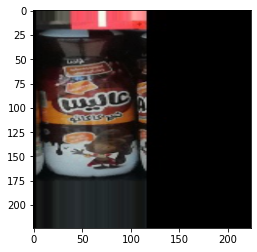

In [7]:
plt.imshow(x[0][0,...].astype(np.uint8))

# CHECK DATA FLOW AND AUGMENTATION

In [13]:
import keras
import sys
sys.path.append('/workspace/product_classifier/')
from utils.data_loader import load_data_flow_from_directory
from utils.image_pp import RandomCutout
import tensorflow as tf
from keras.applications.resnet50 import preprocess_input
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def data_augment(inputs):
    data_augmentation = keras.Sequential(
        [
            #                   tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#                             tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
            # tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
#             tf.keras.layers.experimental.preprocessing.RandomContrast(0.5),
            #                   tf.keras.layers.experimental.preprocessing.RandomZoom(0.4),
            # tf.keras.layers.experimental.preprocessing.RandomTranslation(
                # height_factor=0.2, width_factor=0.2),
            RandomCutout((220, 40)),
            #           tf.keras.layers.experimental.preprocessing.RandomCrop(224,224,),
            #         tf.keras.layers.experimental.preprocessing.Rescaling(),
        ]
    )
    return data_augmentation(inputs)

train_val_dir = '/workspace/product_classifier/data/milk/train-val/'
test_dir = '/workspace/product_classifier/data/milk/test/'


data_flow = \
load_data_flow_from_directory(
    train_val_dir,
    test_dir,
    (224,224),
    1)


inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augment(inputs)
outputs = preprocess_input(x)

model = tf.keras.Model(inputs, outputs)

images = [x[0] for x in list(islice(data_flow['train'], 20))]

for image in images:
    trans_img = model(image)
    trans_img = np.array(trans_img)
    plt.imshow(trans_img[0,...].astype(np.uint8))
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/product_classifier/data/milk/train-val/'